In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import sparse, stats
from sklearn.model_selection import KFold

from pynba import possessions_from_file, use_blackontrans_style

%load_ext pyinstrument

use_blackontrans_style()
league = "nba"
years = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
season_type = "Regular Season"

possessions = pd.concat([possessions_from_file(league, year, season_type) for year in years])
nba_player_ids = pd.read_csv("/home/jupyter/nba/data/NBA_Player_IDs.csv", encoding_errors="ignore")
player_id_mapping = {
    int(player_id): player_name
    for player_name, player_id
    in zip(nba_player_ids["NBAName"], nba_player_ids["NBAID"])
    if not pd.isna(player_id)
}

In [2]:
POSS_COLS = [
    "off_player0", "off_player1", "off_player2", "off_player3", "off_player4", 
    "def_player0", "def_player1", "def_player2", "def_player3", "def_player4",
    "points_scored", "possession_num", "date"
]


def calc_rapm(possessions, half_life, off_prior, def_prior):
    stints = _calc_stints(possessions)
    player_ids = _calc_player_ids(stints)
    n_players = player_ids.shape[0]
    X = _calc_X(stints, player_ids, n_players)
    w = _calc_w(stints, half_life)
    XT_W = _calc_XT_W(X, w)
    y = stints["y"].to_numpy()
    G = _calc_G(XT_W, stints, off_prior, def_prior, n_players)
    A, b = _calc_A_b(X, XT_W, G, y)
    x = _solve_for_x(A, b)
    
    rapm, off_rapm, def_rapm = _calc_rapm(x, n_players)
    rapm_std, off_rapm_std, def_rapm_std = _calc_stds(X, x, y, w, A, n_players)
    off_poss, def_poss, raw_pm, off_raw_pm, def_raw_pm = _calc_raw_stats(XT_W, b, n_players)
    names = _calc_names(player_ids)
    return pd.DataFrame({
        "name": names,
        "rapm": rapm,
        "off_rapm": off_rapm,
        "def_rapm": def_rapm,
        "rapm_std": rapm_std,
        "off_rapm_std": off_rapm_std,
        "def_rapm_std": def_rapm_std,
        "off_poss": off_poss,
        "def_poss": def_poss,
        "raw_pm": raw_pm,
        "off_raw_pm": off_raw_pm,
        "def_raw_pm": def_raw_pm,
    }, index=player_ids)


def _calc_player_ids(stints):
    cols = [f"off_player{ind}" for ind in range(5)] + [f"def_player{ind}" for ind in range(5)]
    return np.unique(stints.loc[:, cols])


def _calc_stints(possessions):
    poss = possessions.loc[:, POSS_COLS]
    off_player_ids = poss[[f"off_player{ind}" for ind in range(5)]].to_numpy()
    off_player_ids.sort(1)
    poss["off_player_ids"] = [row.tobytes() for row in off_player_ids]
    def_player_ids = poss[[f"def_player{ind}" for ind in range(5)]].to_numpy()
    def_player_ids.sort(1)
    poss["def_player_ids"] = [row.tobytes() for row in def_player_ids]
    stints = poss.groupby(by=["date", "off_player_ids", "def_player_ids"]).agg(
        {
            "off_player0": "first",
            "off_player1": "first",
            "off_player2": "first",
            "off_player3": "first",
            "off_player4": "first",
            "def_player0": "first",
            "def_player1": "first",
            "def_player2": "first",
            "def_player3": "first",
            "def_player4": "first",
            "points_scored": "sum",
            "possession_num": "count",
        }
    ).reset_index()
    stints["days_ago"] = _calc_days_ago(stints["date"])
    stints.sort_values("date", inplace=True)
    del stints["off_player_ids"], stints["def_player_ids"]
    stints["mu"], stints["sigma"] = _calc_mu_sigma(possessions, stints)
    stints["y"] = (stints["points_scored"] / stints["possession_num"] * 100 - stints["mu"])
    return stints.reset_index(drop=True)


def _calc_days_ago(dates):
    dates = pd.DatetimeIndex(dates)
    return (dates.max() - dates).days.to_numpy().astype(float)


def _calc_X(stints, player_ids, n_players):
    off_player_ids = stints.loc[:, [f"off_player{ind}" for ind in range(5)]].to_numpy()
    def_player_ids = stints.loc[:, [f"def_player{ind}" for ind in range(5)]].to_numpy()
    n_stints = stints.shape[0]

    X = sparse.lil_matrix((2 * n_players, n_stints))
    for ind, player_id in enumerate(player_ids):
        X[ind, :] = (player_id == off_player_ids).any(1)
        X[n_players + ind, :] = (player_id == def_player_ids).any(1)

    return X.T.tocsr().astype("float64")


def _calc_mu_sigma(possessions, stints):
    alpha = np.exp(np.log(0.5) / 20)
    alpha_4 = np.exp(np.log(0.5) / 100)
    points_df = possessions.groupby(["points_scored", "date"]).agg(count=("off_team_id", "count")).reset_index()
    points_df["days_ago"] = _calc_days_ago(points_df["date"])
    days = points_df["days_ago"].unique()
    points = [1, 2, 3]
    df_dict = {point: [] for point in points + [4]}

    filts = {point: points_df["points_scored"] == point for point in points + [4]}
    
    for day in days:
        weights = (alpha ** np.abs(points_df["days_ago"] - day)) * points_df["count"]
        divisor = weights.sum()
        for point in points:
            est = weights[filts[point]].sum() / divisor
            df_dict[point].append(est)

    for day in days:
        weights = (alpha_4 ** np.abs(points_df["days_ago"] - day)) * points_df["count"]
        divisor = weights.sum()
        est = weights[filts[4]].sum() / divisor
        df_dict[4].append(est)

    df = pd.DataFrame(df_dict, index=days)
    unique_pts = points_df["points_scored"].unique()
    other_pts = unique_pts[unique_pts > 4]
    for point in other_pts:
        df[point] = points_df.loc[points_df["points_scored"] == point, "count"].sum() / points_df["count"].sum()

    df[0] = 1 - df.sum(1)

    df["mu"] = sum([df[point] * point * 100 for point in unique_pts])
    df["var"] = sum([df[point] * (point * 100) ** 2 for point in unique_pts]) - df["mu"] ** 2
    mu = stints["days_ago"].map(df["mu"])
    sigma = np.sqrt(stints["days_ago"].map(df["var"]) / stints["possession_num"])
    return mu, sigma


def _calc_w(stints, half_life):
    alpha = np.exp(np.log(0.5) / (half_life * 365.25))
    days_ago = stints["days_ago"] - stints["days_ago"].min()
    w = stints["possession_num"] * alpha ** days_ago
    return w.to_numpy().astype("float64").reshape(-1, 1)


def _calc_XT_W(X, w):
    return X.multiply(w).T.tocsr()


def _calc_G(XT_W, stints, off_prior, def_prior, n_players):
    normalizer = np.asarray(XT_W.sum(1)).reshape(-1)
    no_samples = normalizer == 0
    normalizer[no_samples] = 1
    variances = XT_W.dot(stints["sigma"] ** 2 * stints["possession_num"]) / normalizer
    variances[no_samples] = stints["sigma"].iloc[-1] ** 2 * stints["possession_num"].iloc[-1]
    diagonal = variances / np.array([off_prior ** 2] * n_players + [def_prior ** 2] * n_players)
    return sparse.diags(diagonal)


def _calc_A_b(X, XT_W, G, y):
    A = XT_W.dot(X) + G
    b = XT_W.dot(y)
    return A, b


def _solve_for_x(A, b):
    return sparse.linalg.spsolve(A, b)


def _calc_rapm(x, n_players):
    off_rapm, def_rapm = x[:n_players], -x[n_players:]
    rapm = off_rapm + def_rapm
    return rapm, off_rapm, def_rapm


def _calc_stds(X, x, y, w, A, n_players):
    r = y - X.dot(x)
    rss = (r * w.reshape(-1)).dot(r)
    sigma2 = rss / (X.shape[0] - X.shape[1])
    cov_x = sigma2 * sparse.linalg.inv(A.tocsc())
    x_var = cov_x.diagonal()
    off_def_cov = cov_x.diagonal(n_players)
    off_rapm_var, def_rapm_var = x_var[:n_players], x_var[n_players:]
    rapm_var = off_rapm_var + def_rapm_var + 2 * off_def_cov
    return np.sqrt(rapm_var), np.sqrt(off_rapm_var), np.sqrt(def_rapm_var)


def _calc_raw_stats(XT_W, b, n_players):
    poss = np.asarray(XT_W.sum(1)).reshape(-1)
    off_poss, def_poss = poss[:n_players], poss[n_players:]
    raw_pms = b / poss
    off_raw_pm, def_raw_pm = raw_pms[:n_players], -raw_pms[n_players:]
    raw_pm = off_raw_pm + def_raw_pm
    return off_poss, def_poss, raw_pm, off_raw_pm, def_raw_pm


def _calc_names(player_ids):
    return [player_id_mapping.get(player_id, "n/a") for player_id in player_ids]

In [3]:
half_life = 1.36
off_prior = 2.69
def_prior = 2.30
%pyinstrument rapm = calc_rapm(possessions, half_life, off_prior, def_prior)

rapm.sort_values(by="rapm", ascending=False).head(30)

/tmp/ipykernel_311/3030414316.py:186: RuntimeWarning: invalid value encountered in true_divide
  raw_pms = b / poss


_     ._   __/__   _ _  _  _ _/_   Recorded: 21:59:35  Samples:  30500
 /_//_/// /_\ / //_// / //_'/ //     Duration: 267.796   CPU time: 795.422
/   _/                      v4.1.1

Program: /home/jupyter/.venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/jupyter/.local/share/jupyter/runtime/kernel-e6fb481c-88ac-436e-8a0f-93bee9a42c8c.json

267.796 <module>  ../../../tmp/ipykernel_311/2642818445.py:2
`- 267.792 calc_rapm  ../../../tmp/ipykernel_311/3030414316.py:8
   |- 166.101 _calc_X  ../../../tmp/ipykernel_311/3030414316.py:82
   |  |- 145.749 __setitem__  scipy/sparse/lil.py:323
   |  |     [75 frames hidden]  scipy, <built-in>, <__array_function_...
   |  |        138.932 lil_fancy_set  <built-in>:0
   |  |- 14.353 [self]  
   |  `- 5.761 __getattr__  scipy/sparse/base.py:673
   |        [23 frames hidden]  scipy, <built-in>
   |- 76.031 _calc_stds  ../../../tmp/ipykernel_311/3030414316.py:171
   |  `- 75.906 inv  scipy/sparse/linalg/matfuncs.py:33
   |        [106 frames hidden]  scipy, <built-in>, numpy, <__array_fu...
   |           72.003 SuperLU.solve  <built-in>:0
   |- 20.188 _calc_stints  ../../../tmp/ipykernel_311/3030414316.py:45
   |  |- 7.897 _calc_mu_sigma  ../../../tmp/ipykernel_311/3030414316.py:95
   |  |  `- 4.508 __array_ufunc__  pandas/core/generic.py:2029
   |  |        [452 frames hidden]  pandas, <built-in>, numpy, typing, abc
   |  `- 5.973 aggregate  pandas/core/groupby/generic.py:964
   |        [169 frames hidden]  pandas, <built-in>, <__array_function...
   `- 3.397 _solve_for_x  ../../../tmp/ipykernel_311/3030414316.py:161
      `- 3.397 spsolve  scipy/sparse/linalg/dsolve/linsolve.py:91
            [9 frames hidden]  scipy, <built-in>

,name,rapm,off_rapm,def_rapm,rapm_std,off_rapm_std,def_rapm_std,off_poss,def_poss,raw_pm,off_raw_pm,def_raw_pm
201939,Stephen Curry,8.540198,5.815221,2.724977,0.660541,0.485122,0.448872,8096.485741,8125.373134,10.343215,6.437713,3.905503
202695,Kawhi Leonard,7.058142,5.130263,1.927880,0.640114,0.467365,0.438426,5586.065304,5592.247902,11.421472,8.406460,3.015012
203507,Giannis Antetokounmpo,6.584601,3.074209,3.510392,0.595859,0.434116,0.408641,9117.403978,9147.203530,9.368004,5.258201,4.109803
101108,Chris Paul,6.483275,3.859659,2.623616,0.570838,0.414439,0.391475,9278.792032,9293.720249,8.498697,6.033273,2.465424
2544,LeBron James,6.459468,5.378233,1.081235,0.557974,0.404796,0.384454,8619.778450,8624.168318,5.813832,4.110018,1.703813
203999,Nikola Jokic,6.232495,4.921989,1.310506,0.653603,0.480407,0.445045,9239.150577,9251.735852,6.449267,6.488168,-0.038901
203497,Rudy Gobert,5.480915,1.345899,4.135016,0.648118,0.475535,0.441254,9545.874173,9544.132872,10.820851,5.177052,5.643800
1628369,Jayson Tatum,5.385618,3.367634,2.017984,0.602914,0.439074,0.413280,9064.566802,9042.521306,5.238809,3.419196,1.819613
201950,Jrue Holiday,5.370956,3.911208,1.459748,0.556457,0.404000,0.383222,9123.963266,9122.842933,6.363394,4.989185,1.374209
203954,Joel Embiid,5.341635,2.499549,2.842085,0.652797,0.477881,0.445931,6496.060620,6507.065252,8.234446,4.044139,4.190308


In [6]:
filt = possessions["year"] == possessions["year"].max()
player_ids = _calc_player_ids(possessions.loc[filt, :])
current_rapm = rapm.loc[player_ids, :]

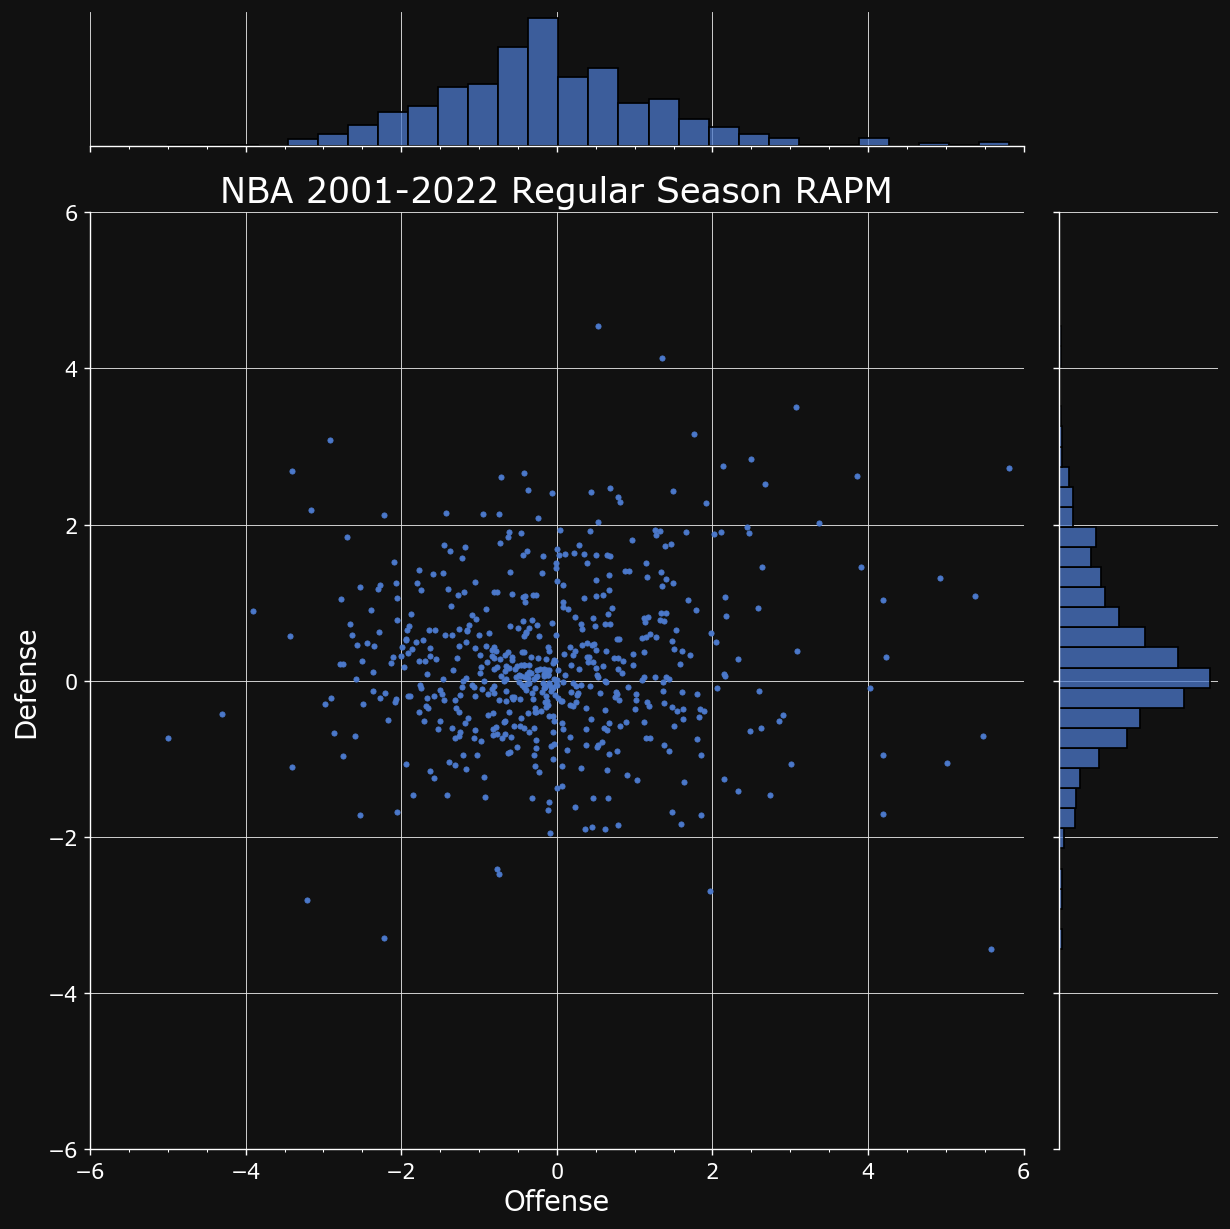

In [7]:
lim = max(np.ceil(current_rapm["off_rapm"].abs().max()), np.ceil(current_rapm["def_rapm"].abs().max()))
joint_grid = sns.jointplot(x=current_rapm["off_rapm"], y=current_rapm["def_rapm"], height=10, xlim=(-lim, lim), ylim=(-lim, lim), marker=".", edgecolor="C0");
joint_grid.ax_joint.set_xlabel("Offense")
joint_grid.ax_joint.set_ylabel("Defense")
joint_grid.ax_joint.set_title(f"{league.upper()} {min(years)}-{max(years)} {season_type} RAPM");